<a href="https://colab.research.google.com/github/drscook/m5364_19fl_Data_Mining1/blob/master/DM2/Intro_to_Rudimentary_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Define functions for later use

import numpy as np
import matplotlib.pyplot as plt
import itertools as it

# common activation functions and their derivatives
def id(x):
    return x

def id_deriv(x):
    return float(1)

def relu(x):
    x[x<0] = 0
    return x

def relu_deriv(x):
    return (x>0).astype(float)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1-tanh(x)**2

def arctan(x):
    return np.arctan(x)
  
def arctan_deriv(x):
    return 1 / (1 + x**2)

def sigmoid(x):
    y = np.zeros_like(x)
    idx = x > -700
    y[idx] = 1 / (1 + np.exp(-1*x[idx]))
    return y

def sigmoid_deriv(x):
    y = sigmoid(x)
    return y * (1 - y)

def loss(e):    
    return (e**2).sum() / 2

def loss_deriv(e):
    return e

def pre_allocate():
    ## pre-allocate
    ## X[h,i,j] = input to node j of layer h for observation i; X[h] has shape n x nodes[h]
    X = [np.zeros(shape=[n,p]) for p in nodes]

    ## Y[h,i,j] = output from node j of layer h for observation i; Y[h] has shape n x nodes[h]
    Y = X.copy()

    ## B[h,j] = bias into node j of layer h; B[h] has shape nodes[h]
    B = [rnd.rand(p) for p in nodes]
    B[0] *= 0.0

    ## W_sh[h] = (nodes[h], nodes[h+1])
    W_sh = [(i,o) for (i,o) in zip(nodes[:-1],nodes[1:])]

    ## W[h,j,k] = weight of edge from node j of layer h to node k of layer h+1; W[h] has shape nodes[h] x nodes[h+1]
    W = [rnd.rand(*ws) for ws in W_sh]

    ## E has shape Y[-1]
    E = Y[-1].copy()
    
    ## DLDX[h,i,j] = partial derivative of loss wrt X[h,i,j]; DLDX[h] has shape n x nodes[h]
    DLDX = X.copy()

    ## DLDY[h,i,j] = partial derivative of loss wrt Y[h,i,j]; DLDY[h] has shape n x nodes[h]
    DLDY = X.copy()

    ## DLDB[h,i,j] = partial derivative of loss wrt B[h,j]; DLDB[h] has shape nodes[h]
    DLDB = [np.zeros_like(b) for b in B]
    
    ## DLDW[h,j,k] = partial derivative of loss wrt W[h,j,k]; DLDW[h] has shape nodes[h] x nodes[h+1]
    DLDW = [np.zeros_like(w) for w in W]

    return X, Y, B, W, E, DLDX, DLDY, DLDB, DLDW

## The scaling below is easier with sklearn.preprocessing.  But I wanted to write a purely Numpy algorithm.
def minmaxscale(x, a=0, b=1):
    m = x.min()
    r = x.max() - m
    if r == 0:
        r = 1
    y = (x - m) / r * (b - a) + a
    return y


def fit_ANN():
    global X, Y, B, W, E, DLDX, DLDY, DLDB, DLDW
    loss_hist = []
    for step in range(max_steps):
        X[0] = feat_sc.copy()
        forward_propagate()
        pred_sc = Y[-1].copy()

        E = true_sc - pred_sc  # note: choice of t-p vs p-t may impact the +/- sign in descend_gradient
        L = loss(E) / n
        loss_hist.append(L)

        if loss_hist[-1] < 1e-4:
            break

        backward_propagate()
        descend_gradient()
    return loss_hist


## functions for pieces of the neural network training
def forward_propagate():
    global X, Y
    for h in range(layers-1):
        Y[h] = activation[h](X[h])
        X[h+1] = Y[h].dot(W[h]) + B[h+1]
    Y[-1] = activation[-1](X[-1])


def backward_propagate():
    global DLDX, DLDY, DLDB, DLDW
    DLDY[-1] = loss_deriv(E)
    for h in reversed(range(1,layers)):
        DLDX[h] = activation_deriv[h](X[h]) * DLDY[h]
        DLDB[h] = DLDX[h].sum(axis=0)
        DLDW[h-1] = (Y[h-1].T).dot(DLDX[h])
        DLDY[h-1] = DLDX[h].dot(W[h-1].T)
#         if h > 1:  ## Don't need to calculate anything for the 0 layer
        

def descend_gradient():
    global B, W
    for h in range(layers-1):
        B[h] += DLDB[h] * learn_rate
        W[h] += DLDW[h] * learn_rate
        
        

In [2]:
## example from https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/, use sigmoid, loss=(e**2)/2 in loss, loss_deriv=e
rnd = np.random.RandomState(42)

feat = np.array([.05,.1]).reshape(1,-1)
true = np.array([.01,.99]).reshape(1,-1)

n, p = feat.shape
m, q = true.shape
if m != n:
    raise Exception('feat and true must have the same number of rows')


hidden_nodes = [2]
max_steps = 1
learn_rate = 0.5

nodes = [p] + hidden_nodes + [q]
layers = len(nodes)

## set activation functions
activation = [sigmoid for l in range(layers)]
activation_deriv = [sigmoid_deriv for l in range(layers)]
activation[0] = id
activation_deriv[0] = id_deriv
# activation[-1] = id
# activation_deriv[-1] = id_deriv


## Usually should scale data to (0,1) during preprocessing.
## Skip for now  to make numbers exactly match Mazur.
feat_sc = feat.copy()
true_sc = true.copy()

X, Y, B, W, E, DLDX, DLDY, DLDB, DLDW = pre_allocate()

## example from https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/, use sigmoid, loss=(e**2)/2 in loss, loss_deriv=e
W = [np.array([[0.15, 0.25], [0.20, 0.30]]), np.array([[0.40, 0.50], [0.45, 0.55]])]
B = [np.array([0.0, 0.0]), np.array([0.35, 0.35]), np.array([0.60, 0.60])]

loss_hist = fit_ANN()     
# %timeit fit_ANN()

for l in range(layers):
    print("layer = {}".format(l))
    print("X")
    print(X[l])
    print("Y")
    print(Y[l])
    print("B")
    print(B[l])
    print("W")
    if l < layers-1:
        print(W[l])
    print()

layer = 0
X
[[0.05 0.1 ]]
Y
[[0.05 0.1 ]]
B
[0. 0.]
W
[[0.14978072 0.24975114]
 [0.19956143 0.29950229]]

layer = 1
X
[[0.3775 0.3925]]
Y
[[0.59326999 0.59688438]]
B
[0.34561432 0.34502287]
W
[[0.35891648 0.51130127]
 [0.40866619 0.56137012]]

layer = 2
X
[[1.10590597 1.2249214 ]]
Y
[[0.75136507 0.77292847]]
B
[0.6 0.6]
W



step = 29668


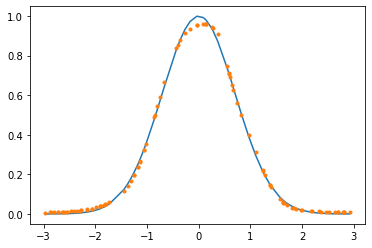

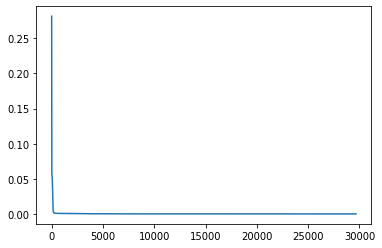

In [3]:
## Build Perceptron to approximate f(x)=e^(-x^2)

rnd = np.random.RandomState(42)

feat = np.sort(rnd.uniform(-3,3,100)).reshape(-1,1)
def f(x):
    return np.exp(-1 * x**2)
true = f(feat)

n, p = feat.shape
m, q = true.shape
if m != n:
    raise Exception('feat and true must have the same number of rows')

hidden_nodes = [5]
max_steps = 100000
learn_rate = 0.1


nodes = [p] + hidden_nodes + [q]
layers = len(nodes)

## set activation functions
activation = [sigmoid for l in range(layers)]
activation_deriv = [sigmoid_deriv for l in range(layers)]
activation[0] = id
activation_deriv[0] = id_deriv
# activation[-1] = id
# activation_deriv[-1] = id_deriv


## Usually should scale data to (0,1) during preprocessing.
## Skip for now  to make numbers exactly match Mazur.
feat_sc = feat.copy()
true_sc = true.copy()

X, Y, B, W, E, DLDX, DLDY, DLDB, DLDW = pre_allocate()

def fit_ANN():
    global X, Y, B, W, E, DLDX, DLDY, DLDB, DLDW
    loss_hist = []
    for step in range(max_steps):
        X[0] = feat_sc.copy()
        forward_propagate()
        pred_sc = Y[-1].copy()

        E = true_sc - pred_sc  # note: choice of t-p vs p-t may impact the +/- sign in descend_gradient
        L = loss(E) / n
        loss_hist.append(L)

        if loss_hist[-1] < 1e-4:
            break

    #     dt = 100
    #     if (step > dt) and (loss_hist[-dt] - loss_hist[-1]) / dt < 1e-8:
    #         break

        backward_propagate()
        descend_gradient()
    return loss_hist

loss_hist = fit_ANN()     
#%time 
fit_ANN()
print('step = {}'.format(len(loss_hist)))
fig = plt.plot()
plt.plot(feat_sc, true_sc)
plt.plot(feat_sc, Y[-1], '.')
plt.show()

fig = plt.plot()
plt.plot(loss_hist)
plt.show()


# for l in range(layers):
#     print("layer = {}".format(l))
#     print("X")
#     print(X[l])
#     print("Y")
#     print(Y[l])
#     print("B")
#     print(B[l])
#     print("W")
#     if l < layers-1:
#         print(W[l])
#     print()